# Analysis of 20161205_BS15_S750glc

### Load modules

In [65]:
# import modules
import sys
import os
import time
import inspect
import getopt
import yaml
from pprint import pprint # for human readable file output
try:
    import cPickle as pickle
except:
    import pickle
import numpy as np
import scipy.stats as sps
import pandas as pd
from pprint import pprint
from IPython.display import display, HTML

from scipy.optimize import curve_fit

# you need to import mm3_helpers
sys.path.insert(0, '../../mm3/')
import mm3_helpers as mm3

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 10, 10
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

pd.options.display.float_format = '{:,.3f}'.format

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.25)

### Load experiment specific files

In [2]:
param_file_path = '../../params.yaml'
params = mm3.init_mm3_helpers(param_file_path)

# load specs file
with open(params['ana_dir'] + '/specs.pkl', 'r') as specs_file:
    specs = pickle.load(specs_file)
    
# load cell data dict
with open(params['cell_dir'] + 'mother_cells.pkl', 'r') as cell_file:
    Cells = pickle.load(cell_file)

In [3]:
# how many channels do we have analyzed? 
channel_no = 0
for fov_id in specs.keys():
    for peak_id, spec in specs[fov_id].items():
        if spec == 1:
            channel_no += 1
print('There are %d channels analyzed' % channel_no)

There are 1150 channels analyzed


### Load cells and make various other containers

In [53]:
### Distributions of filtered parameters
labels = ['sb', 'sd', 'delta', 'tau', 'elong_rate', 'septum_position']

# Make dataframe for plotting variables
Cells_dict = {cell_id : vars(cell) for cell_id, cell in Cells.iteritems()}
Cells_df = pd.DataFrame(Cells_dict).transpose() # must be transposed so data is in columns
Cells_df = Cells_df.sort(columns=['fov', 'peak', 'birth_time', 'birth_label']) # sort for convinience
plot_columns = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'septum_position']
plot_df = Cells_df[plot_columns].astype(np.float)

# Calculate basic stats
cell_stats = plot_df.describe()
display(cell_stats)

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


sb         sd      delta  elong_rate        tau  septum_position
count 29,401.000 29,401.000 29,401.000  29,401.000 29,401.000       29,401.000
mean       5.089      9.407      4.317       0.041     32.296            0.519
std        3.872      5.586      3.087       0.008     12.587            0.078
min        1.562      1.987     -1.511      -0.046      2.000            0.037
25%        3.188      6.185      2.676       0.039     26.000            0.491
50%        3.602      6.926      3.242       0.042     32.000            0.514
75%        4.785      9.341      4.455       0.045     38.000            0.537
max       28.350     31.446     25.272       0.182    448.000            0.977

### Filter Cells dictionary
* filtered data for all stats to within 2 standard deviations of the median 

In [54]:
fCells = {} # dict to hold filtered cells
for cell_id, Cell in Cells_dict.iteritems():
    benchmark = 0 # this needs to equal 6, so it passes all tests
    for label in labels:
        low_bound = cell_stats[label]['50%'] - 2*cell_stats[label]['std']
        high_bound = cell_stats[label]['50%'] + 2*cell_stats[label]['std']
        if Cell[label] > low_bound and Cell[label] < high_bound:
            benchmark += 1
    if benchmark == 6:
        fCells[cell_id] = Cells[cell_id]
            
# Make plotting datafram using the filtered cells
fCells_dict = {cell_id : vars(cell) for cell_id, cell in fCells.iteritems()}
fCells_df = pd.DataFrame(fCells_dict).transpose() # must be transposed so data is in columns
fCells_df = fCells_df.sort(columns=['fov', 'peak', 'birth_time', 'birth_label']) # sort for convinience
fplot_df = fCells_df[plot_columns].astype(np.float)

display(fplot_df.describe())

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


sb         sd      delta  elong_rate        tau  septum_position
count 24,235.000 24,235.000 24,235.000  24,235.000 24,235.000       24,235.000
mean       3.875      7.370      3.496       0.042     31.822            0.514
std        1.364      2.305      1.375       0.004      8.137            0.034
min        1.562      2.312      0.470       0.027      8.000            0.359
25%        3.139      6.090      2.654       0.039     26.000            0.493
50%        3.477      6.669      3.131       0.042     32.000            0.514
75%        4.000      7.586      3.821       0.044     36.000            0.535
max       11.339     18.087      9.413       0.057     56.000            0.670

## Plot traces

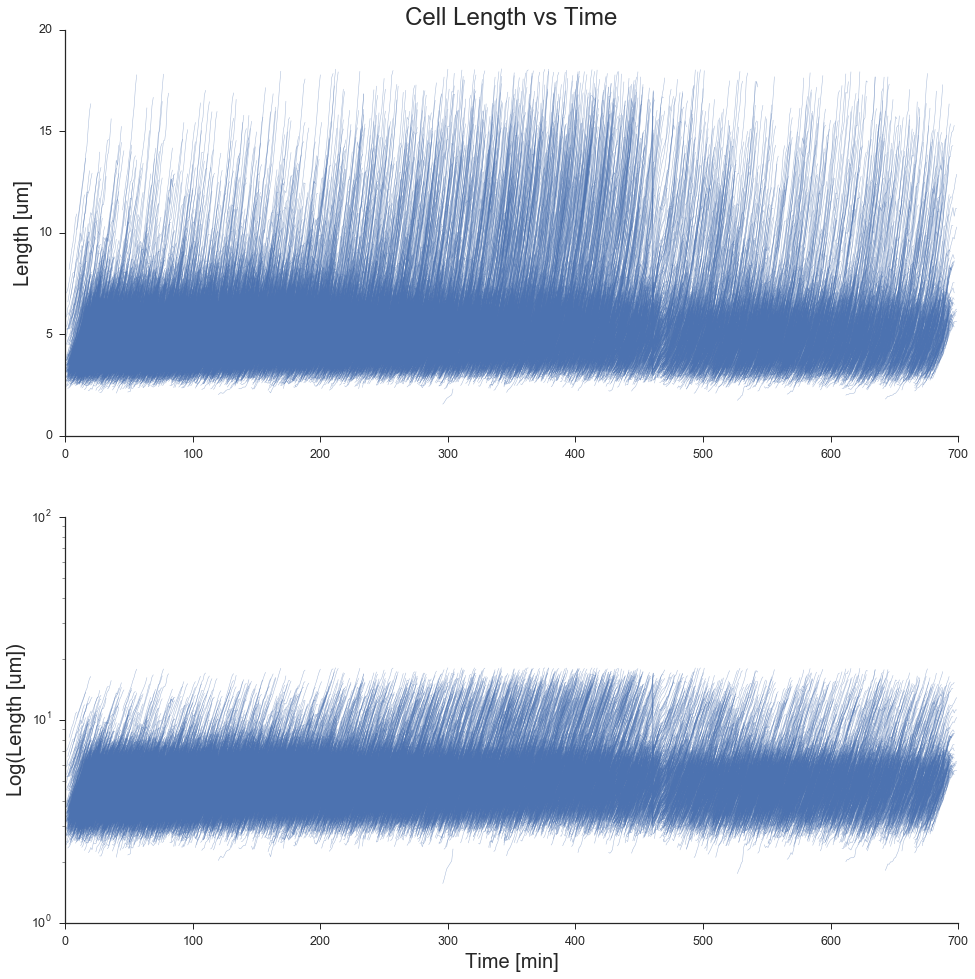

In [50]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(16, 16))
ax = axes.flat # same as axes.ravel()

for cell_id, cell in fCells.iteritems():

    ax[0].plot(cell.times_w_div, cell.lengths_w_div, 'b-', lw=.5, alpha=0.5)
    ax[1].semilogy(cell.times_w_div, cell.lengths_w_div, 'b-', lw=.5, alpha=0.5)

ax[0].set_title('Cell Length vs Time', size=24)
ax[1].set_xlabel('Time [min]', size=20)
ax[0].set_ylabel('Length [um]', size=20)
ax[1].set_ylabel('Log(Length [um])', size=20)
# ax[0].set_ylim([0,10])
# ax[1].set_ylim([0,10])

sns.despine()
#plt.save
# plt.savefig(plot_dir + 'traces.png')

## Plot histograms

sb, mean=3.875, std=1.364, cv=0.352
sd, mean=7.370, std=2.305, cv=0.313
delta, mean=3.496, std=1.375, cv=0.393
tau, mean=31.822, std=8.137, cv=0.256
elong_rate, mean=0.042, std=0.004, cv=0.100
septum_position, mean=0.514, std=0.034, cv=0.066


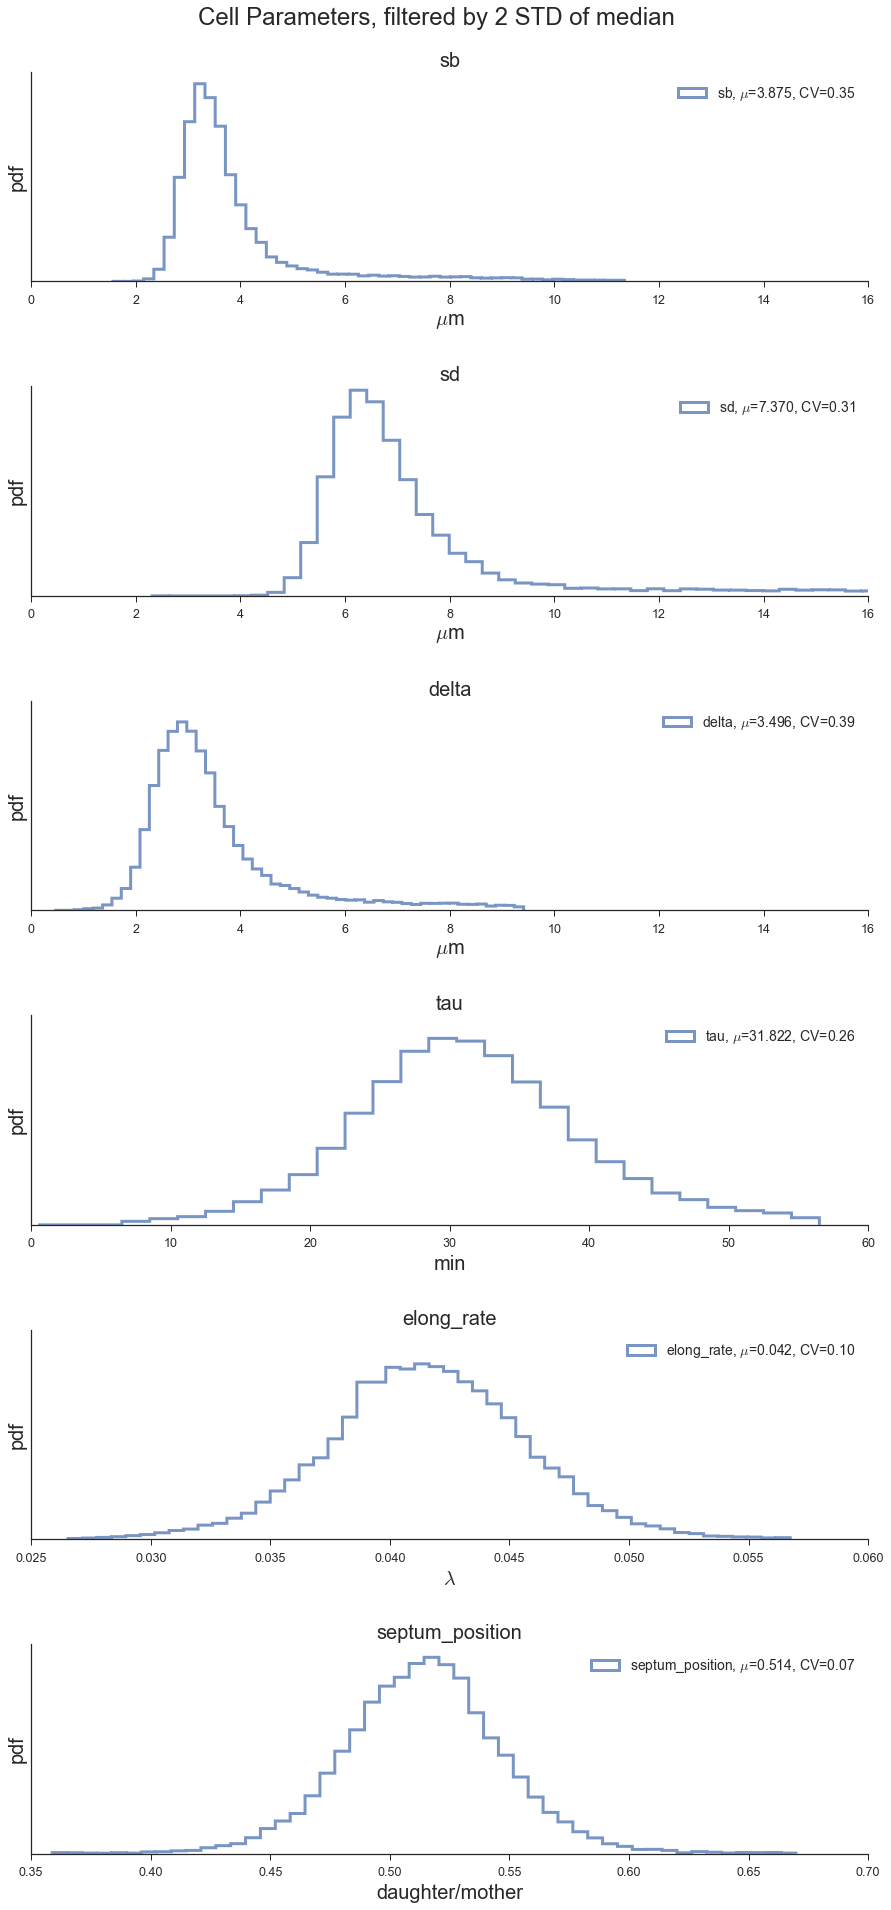

In [52]:
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=[15,30], squeeze=False)
ax = np.ravel(axes)

xlabels = ['$\mu$m', '$\mu$m', '$\mu$m', 'min', '$\lambda$', 'daughter/mother']

for i, label in enumerate(labels):
    filtered_data = fplot_df[label]

    # and the new mean and std
    fil_data_mean = filtered_data.mean()
    fil_data_std = filtered_data.std()
    fil_data_max = filtered_data.max()
    fil_data_min = filtered_data.min()
    fil_data_cv = fil_data_std / fil_data_mean
    print('%s, mean=%.3f, std=%.3f, cv=%.3f' % (label, fil_data_mean, fil_data_std, fil_data_cv))

    if label == 'tau':
        bin_edges = np.array(range(0, int(fil_data_max)+1, 2)) + 0.5
        n, bins, patches = ax[i].hist(filtered_data, bins=bin_edges, 
                   histtype='step', normed=True, lw=3, alpha=0.75)
    else:
        ax[i].hist(filtered_data, bins=50, 
                   histtype='step', normed=True, lw=3, alpha=0.75)

    ax[i].set_title(label, size=20)
    ax[i].set_xlabel(xlabels[i], size=20)
    ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylabel('pdf', size=20)
    
    if label == 'sb' or label == 'sd' or label == 'delta':
        ax[i].set_xlim([0, 16])

    ax[i].legend(['%s, $\mu$=%.3f, CV=%.2f' % (label, fil_data_mean, fil_data_cv)], fontsize=14)

fig.suptitle('Cell Parameters, filtered by 2 STD of median', size=24)
plt.subplots_adjust(top=.95, hspace=0.5)

sns.despine()
plt.show()
# plt.savefig(plot_dir + 'distributions.png')

### Lineage traces

In [55]:
Lineages = mm3.organize_cells_by_channel(fCells, specs)

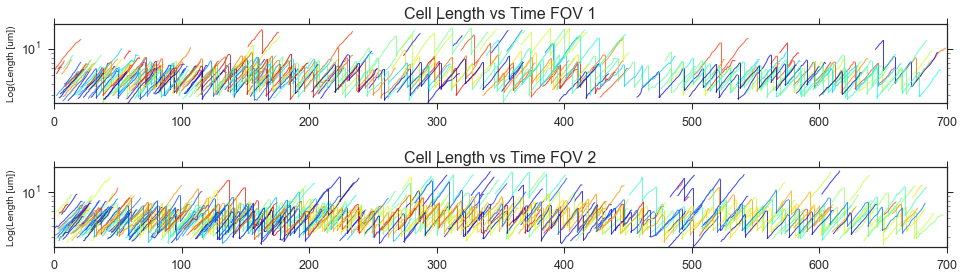

In [56]:
fig, axes = plt.subplots(ncols=1, nrows=2, #len(Lineages.keys()),
                         figsize=(16, 4))
#                          figsize=(16, 2*len(Lineages.keys())))
ax = axes.flat 

# for i, fov in enumerate(Lineages.keys()):
for i, fov in enumerate([1,2]):
    # record max div length for whole FOV to set y lim
    max_div_length = 0 
    
    for peak, lin in Lineages[fov].iteritems():
        # this is to map mothers to daugthers with lines 
        last_div_time = None
        last_length = None
        
        # turn it into a list so it retains time order
        lin = [(cell_id, cell) for cell_id, cell in lin.iteritems()]
        lin = sorted(lin, key=lambda x: x[0])
#         pprint(lin)
        
        for cell_id, cell in lin:
            ax[i].semilogy(cell.times_w_div, cell.lengths_w_div, 
                           color=plt.cm.jet(int(255*peak/2600)), lw=1, alpha=0.75)
            
            # draw a connecting lines betwee mother and daughter
            
#             print(cell.birth_time, last_div_time)
            if cell.birth_time == last_div_time:
                ax[i].semilogy([last_div_time, cell.birth_time],
                               [last_length, cell.sb], 
                               color=plt.cm.jet(int(255*peak/2600)), lw=1, alpha=0.75)
            
            # record the last division time and length for next time 
            last_div_time = cell.division_time
            last_length = cell.sd
            
            # same the max div length for axis plotting
            if last_length > max_div_length:
                max_div_length = last_length

    title_string = 'Cell Length vs Time FOV %d' % fov
    ax[i].set_title(title_string, size=16)
    ax[1].set_xlabel('Time [min]', size=20)
    ax[i].set_ylabel('Log(Length [um])', size=10)
    ax[i].set_ylim([0, max_div_length + 2])

plt.subplots_adjust(hspace=0.8)
# plt.show()
plt.savefig('/Users/jt/Desktop/lineages.png', dpi=300)

## scatter plots over time

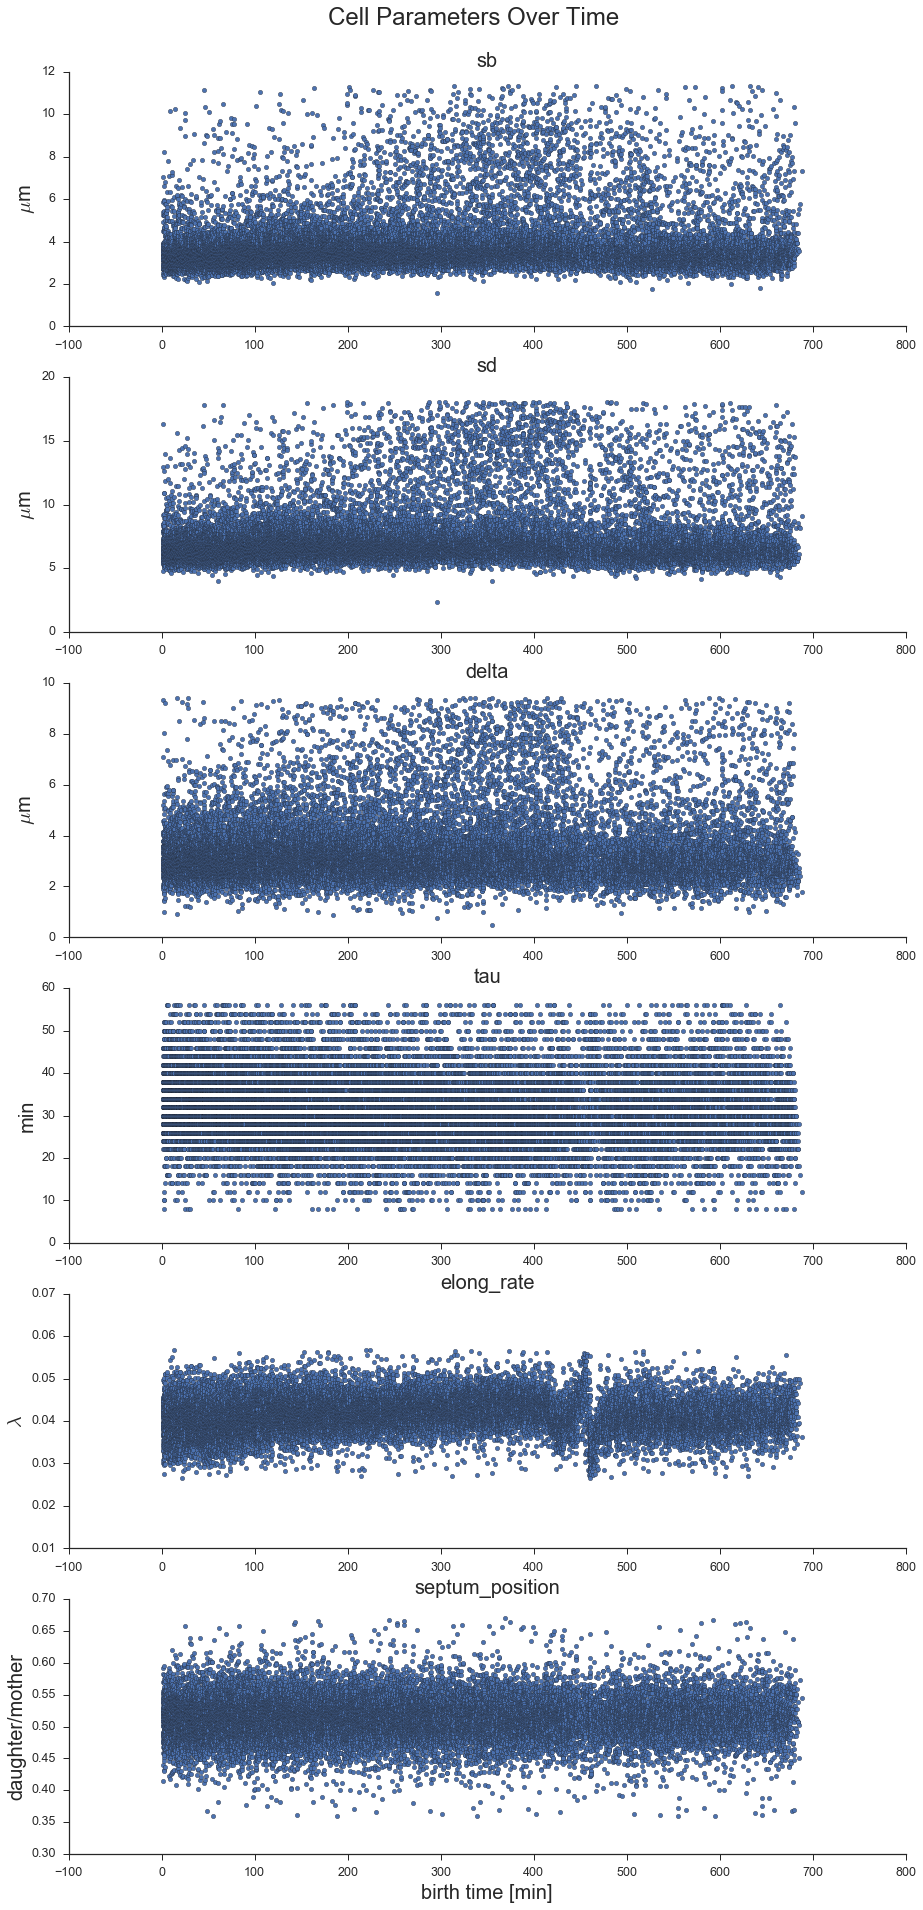

In [201]:
ylabels = ['$\mu$m', '$\mu$m', '$\mu$m', 'min', '$\lambda$', 'daughter/mother']

fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=[15,30], squeeze=False)
ax = np.ravel(axes)

# Now plot the filtered data    
for i, label in enumerate(labels):
    
    # get out just the data to be plot for one subplot
    columns = ['birth_time', label]
    time_df = fCells_df[columns]
    time_df = time_df[columns].apply(pd.to_numeric)
    time_df = time_df.reset_index()
    time_df = time_df[columns]
    time_df.sort_values(by='birth_time', inplace=True)
    
    ax[i].scatter(time_df['birth_time'], time_df[label])
    
    ax[i].set_title(label, size=20)
#     ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylabel(ylabels[i], size=20)
#     ax[i].set_xlim([0,200])
    
ax[i].set_xlabel('birth time [min]', size=20)
    
# plt.tight_layout()

# Make title, need a little extra space
plt.subplots_adjust(top=0.95)
fig.suptitle('Cell Parameters Over Time', size=24)

sns.despine()
plt.show()

## Hex plot of the same thing

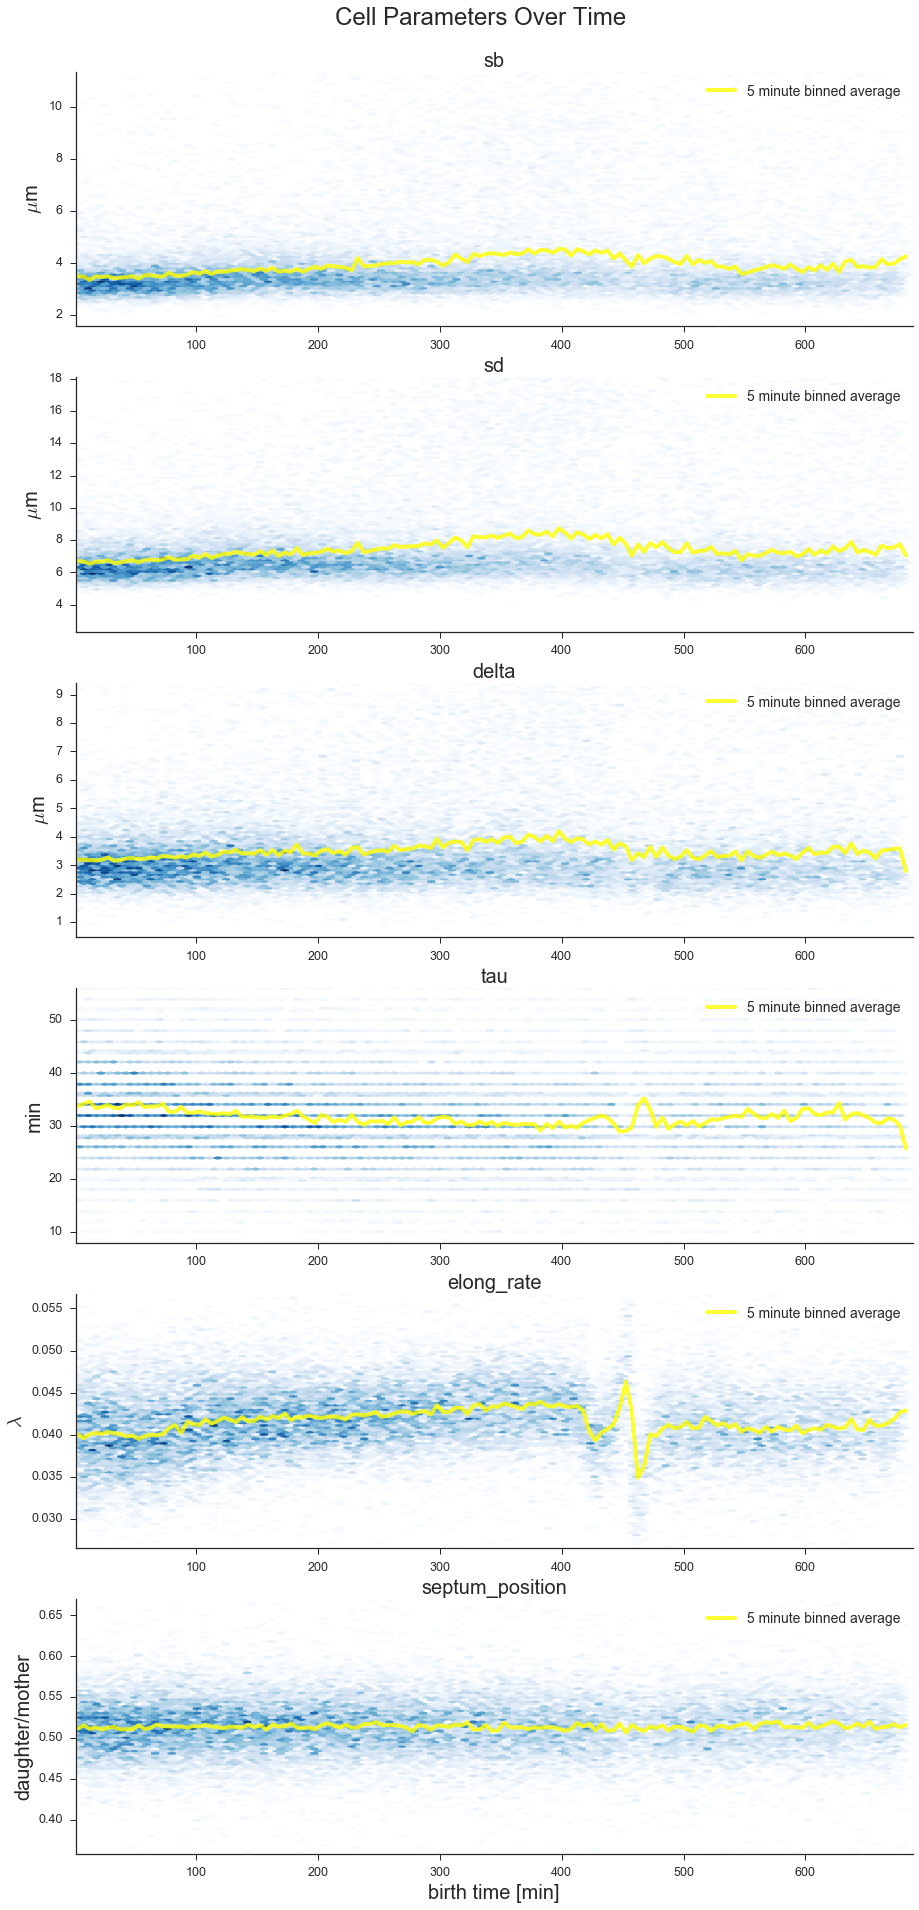

In [200]:
# sets color and other styles for hexbin
def hexbin_style(p):
    p.set_cmap(cmap=plt.cm.Blues) # set color
    return

# sets color and styles for 2d histogram
def hist2d_style(p):
    p.set_cmap(cmap=plt.cm.Blues)
    return

# binning parameters, should be arguments
binmin = 1 # minimum bin size to display
bingrid = 50 # size of each bin 

# binex_um = (hrs[0],hrs[1],ylim_um[0],ylim_um[1]) # size of area to plot for length plots
# binex_gr = (hrs[0],hrs[1],ylim_gr[0],ylim_gr[1])
# binex_tau = (hrs[0],hrs[1],ylim_tau[0],ylim_tau[1])

ylabels = ['$\mu$m', '$\mu$m', '$\mu$m', 'min', '$\lambda$', 'daughter/mother']

fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=[15,30], squeeze=False)
ax = np.ravel(axes)

# Now plot the filtered data    
for i, label in enumerate(labels):
    
    # get out just the data to be plot for one subplot
    columns = ['birth_time', label]
    time_df = fCells_df[columns]
    time_df = time_df[columns].apply(pd.to_numeric)
    time_df = time_df.reset_index()
    time_df = time_df[columns]
    time_df.sort_values(by='birth_time', inplace=True)

    # limits on the x axis
    xlims = (time_df['birth_time'].min(), time_df['birth_time'].max())
    
    p = ax[i].hexbin(time_df['birth_time'], time_df[label],
                     mincnt=binmin) #, gridsize=bingrid)
    
    # graph stats
    bin_mean, bin_edges, binnumber = sps.binned_statistic(time_df['birth_time'], time_df[label], 
                                                          statistic='mean', 
                                                          bins=np.arange(xlims[0]-1,xlims[1]+1,5))                                              
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    ax[i].plot(bin_centers, bin_mean, lw=4, alpha=0.8, color=(1.0, 1.0, 0.0))
    
    
    ax[i].set_title(label, size=20)
#     ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylabel(ylabels[i], size=20)

    hexbin_style(p) # set color and style 
    
    ax[i].legend(['5 minute binned average'], fontsize=14)
    
ax[i].set_xlabel('birth time [min]', size=20)
    
# plt.tight_layout()

# Make title, need a little extra space
plt.subplots_adjust(top=0.95)
fig.suptitle('Cell Parameters Over Time', size=24)

sns.despine()
plt.show()

## Violin plot of parameters across FOVS

In [125]:
violin_columns = ['fov', 'sb', 'sd', 'delta', 'elong_rate', 'tau', 'septum_position']
violin_df = fCells_df[violin_columns].astype(np.float)
violin_df['fov'] = violin_df['fov'].astype(np.int)
# violin_df

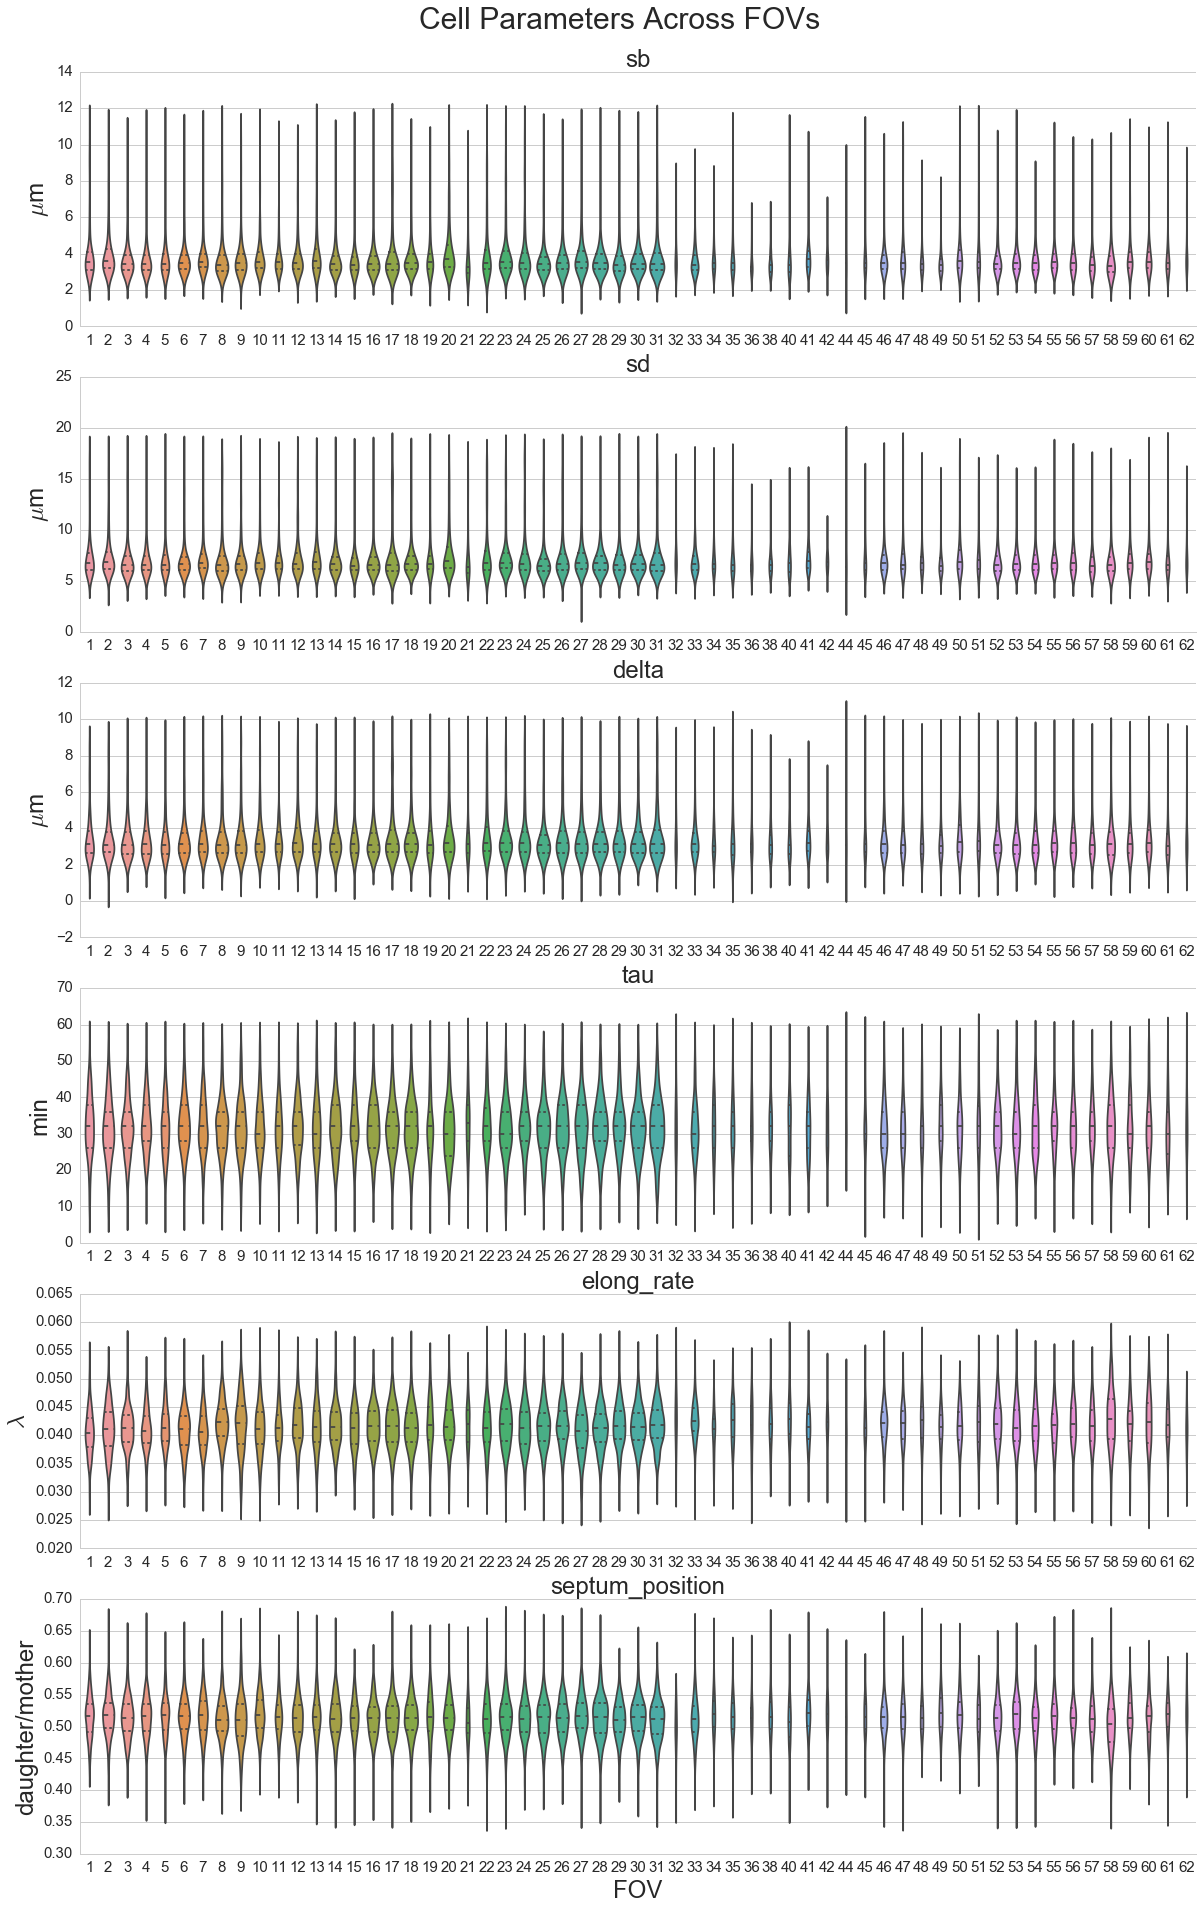

In [134]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)

ylabels = ['$\mu$m', '$\mu$m', '$\mu$m', 'min', '$\lambda$', 'daughter/mother']

fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=[20,5*len(labels)], squeeze=False)
ax = np.ravel(axes)

for i, label in enumerate(labels):
    # Draw a nested violinplot and split the violins for easier comparison
    sns.violinplot(x="fov", y=label, data=violin_df,
                  scale="count", inner="quartile", ax=ax[i], lw=3)
    
    ax[i].set_title(label, size=24)
    ax[i].set_ylabel(ylabels[i], size=24)
    ax[i].set_xlabel('')
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    
ax[i].set_xlabel('FOV', size=24)
    
# plt.tight_layout()

# Make title, need a little extra space
plt.subplots_adjust(top=0.95)
fig.suptitle('Cell Parameters Across FOVs', size=30)

sns.despine()
plt.show()

## Correlations of parameters

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


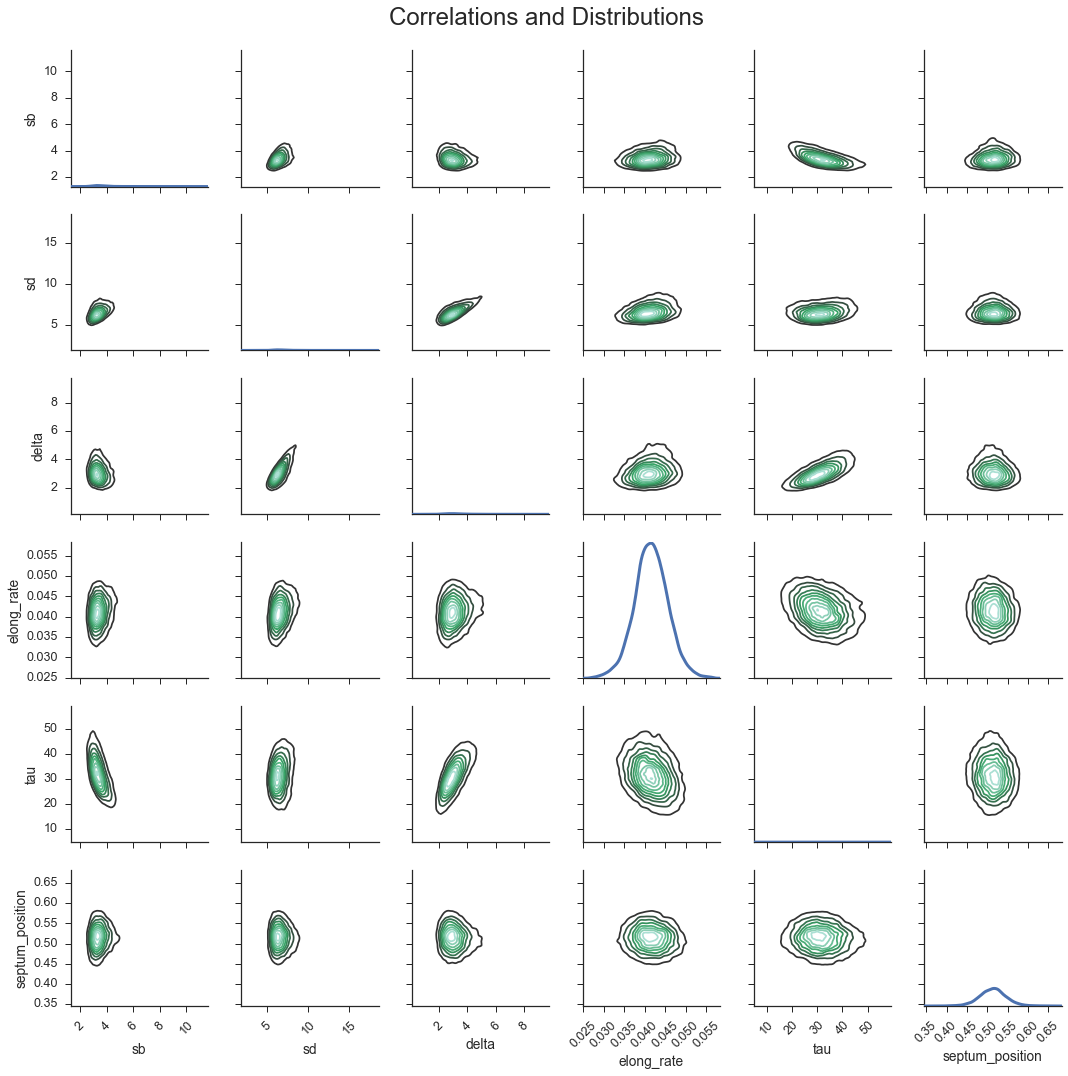

In [158]:
sns.set(style="ticks", color_codes=True, font_scale=1.25)

### correlations
# g = sns.pairplot(fplot_df, kind=sns.kdeplot, diag_kind='kde')
# # g.map_offdiag(sns.kdeplot)

g = sns.PairGrid(fplot_df)
g = g.map_diag(sns.kdeplot, lw=3)
g = g.map_offdiag(sns.kdeplot, lw=1)


# Make title, need a little extra space
plt.subplots_adjust(top=0.94)
g.fig.suptitle('Correlations and Distributions', size=24)

for ax in g.axes.flatten():
    for t in ax.get_xticklabels():
        t.set(rotation=45)

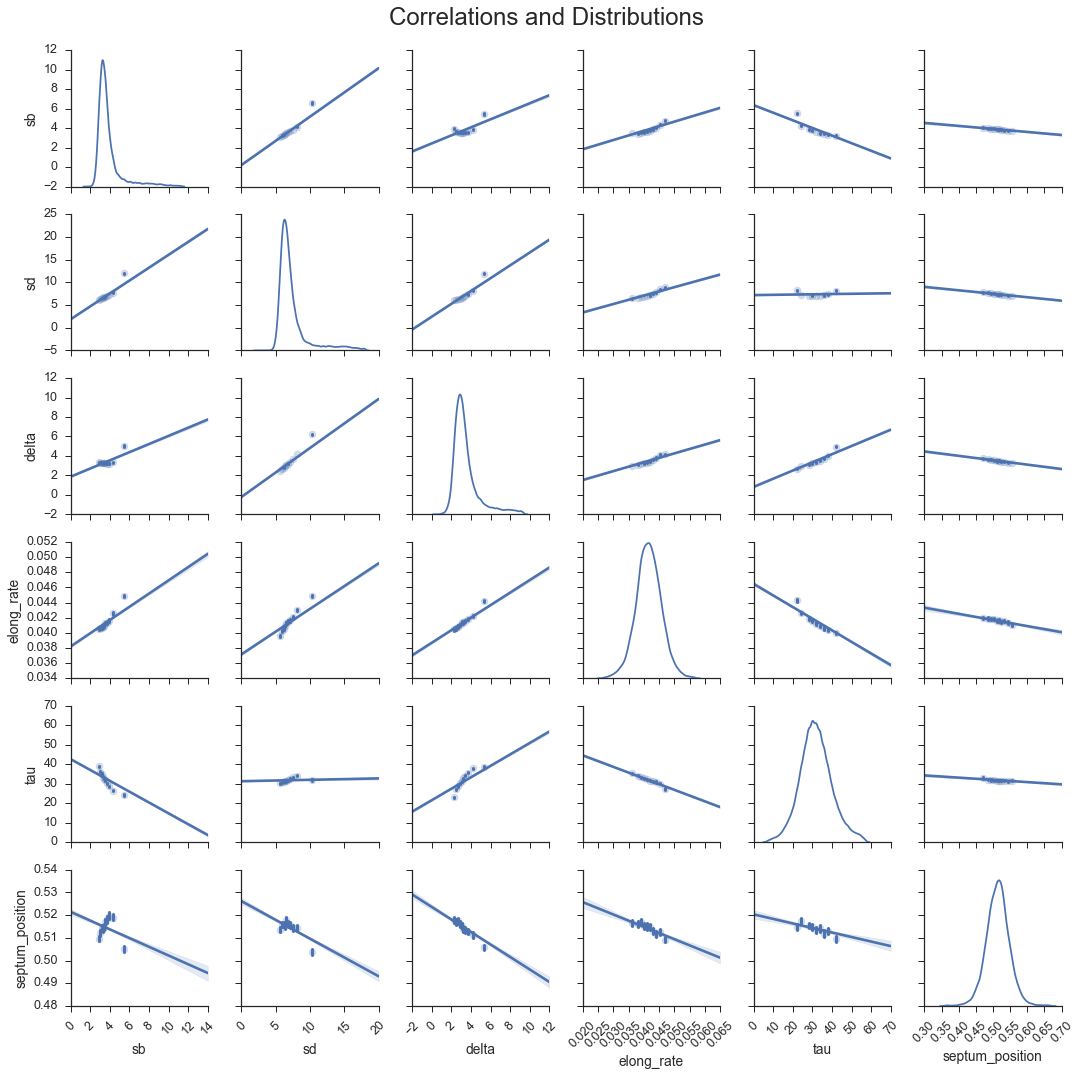

In [153]:
sns.set(style="ticks", color_codes=True, font_scale=1.25)

### correlations
g = sns.pairplot(fplot_df, kind='reg', diag_kind='kde', 
                 plot_kws={'scatter':True, 'x_bins':10,
                          'scatter_kws':{'alpha':0.25}})


# Make title, need a little extra space
plt.subplots_adjust(top=0.94)
g.fig.suptitle('Correlations and Distributions', size=24)

for ax in g.axes.flatten():
    for t in ax.get_xticklabels():
        t.set(rotation=45)